# Ex06 뉴스 요약봇 만들기

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(1).to_dict()

{'headlines': {91957: 'Reliance reports 45% rise in revenue for March quarter'},
 'text': {91957: 'Mukesh Ambani-led Reliance Industries posted a 45.2% rise in consolidated revenue to Ã¢Â\x82Â¹92,889 crore for the March quarter. The company also reported a 12.3% year-on-year increase in net profit to Ã¢Â\x82Â¹8,046 crore. The boost came after posting higher-than-expected gross refining margin. Notably, telco Reliance Jio posted a net loss of Ã¢Â\x82Â¹22.5 crore for the six months ended March 31.'}}

In [4]:
data[:1].to_dict()

{'headlines': {0: 'upGrad learner switches to career in ML & Al with 90% salary hike'},
 'text': {0: "Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."}}

In [6]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98360


### 데이터 전처리

In [8]:
# 중복된 데이터를 제거하기
data.drop_duplicates(subset = ['text'], inplace=True)
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


In [9]:
print(data.isnull().sum()) # null 값의 유무 확인

headlines    0
text         0
dtype: int64


In [10]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 불용어 사전 불러오기

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    # sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
temp_headline = "SRK, Ranveer or Saif to replace Varun in Judwaa 3: Report"
temp_text = 'According to reports, Shah Rukh Khan, Ranveer Singh or Saif Ali Khan will replace Varun Dhawan in \'Judwaa 3\'. A source said, "Every Judwaa film will feature a new A-lister in a double role." Filmmaker David Dhawan, who directed \'Judwaa\' and \'Judwaa 2\', will reportedly also direct all the upcoming films in the franchise. '

print("headline:", preprocess_sentence(temp_headline, False))  # 불용어를 제거하지 않습니다.
print("text: ", preprocess_sentence(temp_text))

headline: srk ranveer or saif to replace varun in judwaa report
text:  according reports shah rukh khan ranveer singh saif ali khan replace varun dhawan judwaa source said every judwaa film feature new lister double role filmmaker david dhawan directed judwaa judwaa reportedly also direct upcoming films franchise


In [14]:
# 전체 Text 데이터에 대한 전처리
clean_headlines = []

for headline in data['headlines']:
    clean_headlines.append(preprocess_sentence(headline))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_headlines[:5])

# 전체 Headline 데이터에 대한 전처리 
clean_texts = []

for text in data['text']:
    clean_texts.append(preprocess_sentence(text, False))

print("Summary 전처리 후 결과: ", clean_texts[:5])

Text 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']
Summary 전처리 후 결과:  ['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more', 'new zealand d

In [15]:
# 전처리 된 결과를 데이터프레임에 담는다.
data['headlines'] = clean_headlines
data['text'] = clean_texts

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
data.isnull().sum() # 실행해보면 null값은 없는 것을 알 수 있다.

headlines    0
text         0
dtype: int64

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.136787364393153
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.18195233152185


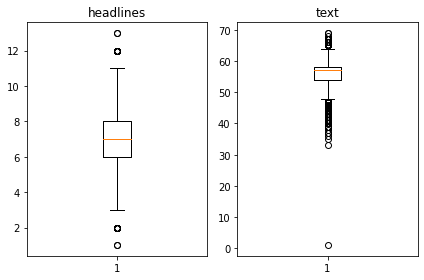

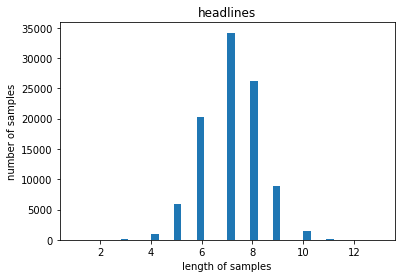

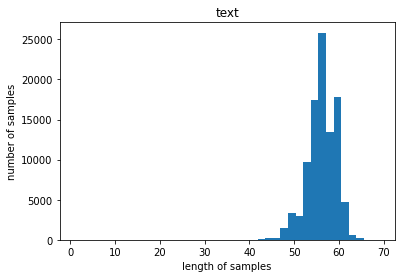

In [17]:
# 길이 분포 출력

headline_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
headline_max_len = 10
text_max_len = 60

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(headline_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9978323258228002
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9443528525778022


In [21]:
# headline_max_len, text_max_len보다 긴 문장들은 제외시킨다.

data['headlines2'] = data['headlines'].apply(lambda x: len(x.split()) > headline_max_len)
data['text2'] = data['text'].apply(lambda x: len(x.split()) > text_max_len)

data.drop(data[data['headlines2'] == True].index, inplace=True)
data.drop(data[data['text2'] == True].index, inplace=True)

data.drop(labels='headlines2', axis=1, inplace=True)
data.drop(labels='text2', axis=1, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 92602


In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant an alumnus of upgrad and iiit pg p...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking about the sexual harassment allegatio...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[29155 15175 41407 ... 36383 23089 59318]


In [37]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [38]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18520


In [39]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 74082
훈련 레이블의 개수 : 74082
테스트 데이터의 개수 : 18520
테스트 레이블의 개수 : 18520


### 정수 인코딩

In [40]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [41]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68185
등장 빈도가 6번 이하인 희귀 단어의 수: 46483
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21702
단어 집합에서 희귀 단어의 비율: 68.17188531201877
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.274390640226142


In [42]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 21,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [43]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1, 74, 48, 7, 155, 126, 5, 87, 8, 112, 6804, 1877, 4, 278, 6, 1457, 2093, 8, 1340, 279, 1, 1779, 411, 5124, 43, 970, 4, 118, 129, 286, 4, 31, 97, 48, 542, 11, 256, 48, 356, 5366, 94, 18, 126, 1463, 10, 33, 221, 11, 76, 171, 6, 1457, 397, 292, 1428], [1, 48, 7, 690, 16271, 3, 1231, 3, 11539, 4634, 1286, 259, 334, 5, 930, 1, 48, 101, 49, 16271, 3, 1231, 4, 20280, 10966, 10018, 998, 6, 776, 425, 7467, 1014, 5, 10967, 1341, 19, 109, 344, 4, 1, 259, 17, 9, 7692, 21, 24, 9073, 15, 110, 2, 338, 91, 25, 32, 895], [1587, 404, 4497, 13950, 3694, 28, 11, 1, 46, 313, 12612, 2, 2462, 4040, 844, 3, 10968, 22, 1, 1676, 4289, 15002, 17101, 8, 5180, 1, 2721, 3, 29, 17, 12, 681, 2, 588, 12612, 92, 15002, 28, 11, 803, 2, 8923, 2954, 3, 96, 196, 91, 35, 117, 303, 52, 188, 3694, 9, 3, 23, 1127]]


In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [45]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29330
등장 빈도가 5번 이하인 희귀 단어의 수: 19371
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9959
단어 집합에서 희귀 단어의 비율: 66.04500511421753
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.138511189180745


In [50]:
tar_vocab = 9900
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 9, 4876, 75, 3970, 129, 1084, 1561, 173], [1, 2539, 305, 2652], [1, 2420, 4877, 7731, 2653, 7242, 3], [1, 3971, 1215, 376, 367, 730, 148, 6448, 4227], [1, 102, 508, 34, 3491, 6449, 520, 106]]
target
decoder  [[9, 4876, 75, 3970, 129, 1084, 1561, 173, 2], [2539, 305, 2652, 2], [2420, 4877, 7731, 2653, 7242, 3, 2], [3971, 1215, 376, 367, 730, 148, 6448, 4227, 2], [102, 508, 34, 3491, 6449, 520, 106, 2]]


In [51]:
# 길이가 1인 headline을 삭제한다.

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 4
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74078
훈련 레이블의 개수 : 74078
테스트 데이터의 개수 : 18520
테스트 레이블의 개수 : 18520


In [52]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

### 모델 설계 및 훈련

In [53]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [54]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [55]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [56]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [57]:
# 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
290/290 [==============================] - 71s 106ms/step - loss: 5.6324 - val_loss: 5.2728
Epoch 2/50
290/290 [==============================] - 30s 105ms/step - loss: 5.1681 - val_loss: 4.9078
Epoch 3/50
290/290 [==============================] - 31s 108ms/step - loss: 4.8058 - val_loss: 4.6714
Epoch 4/50
290/290 [==============================] - 32s 110ms/step - loss: 4.5357 - val_loss: 4.4642
Epoch 5/50
290/290 [==============================] - 32s 109ms/step - loss: 4.3189 - val_loss: 4.2953
Epoch 6/50
290/290 [==============================] - 32s 110ms/step - loss: 4.1352 - val_loss: 4.1993
Epoch 7/50
290/290 [==============================] - 32s 110ms/step - loss: 3.9757 - val_loss: 4.0775
Epoch 8/50
290/290 [==============================] - 32s 110ms/step - loss: 3.8353 - val_loss: 4.0175
Epoch 9/50
290/290 [==============================] - 32s 110ms/step - loss: 3.7121 - val_loss: 3.9561
Epoch 10/50
290/290 [==============================] - 32s 110ms/step - l

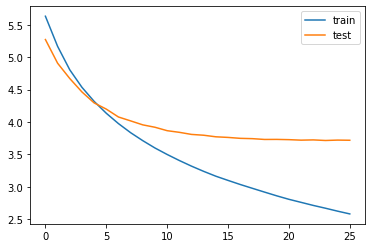

In [58]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [59]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [60]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


=3


In [61]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [65]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [72]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    temp = temp.replace("sostoken", "").replace("eostoken", "")
    return temp

=3


In [73]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : saif ali khan will reportedly make comeback in the race franchise by starring in race saif who starred in race and race has been approached by ramesh taurani to join the race franchise again as per reports race which was directed by remo souza starred salman khan anil kapoor bobby deol jacqueline fernandez and daisy shah 
실제 요약 :  saif ali khan join race franchise reports 
예측 요약 :  katrina shares pic saif sets race


원문 : while speaking about the roles written for older women in indian films veteran actress said after certain age you are given nothing to do same old thing again and again do mother role here and mother role there the actress added will be seen playing grandmother in upcoming horror web series 
실제 요약 :  certain age given role mother 
예측 요약 :  think girl life days


원문 : the anti corruption bureau has said ex delhi minister kapil mishra has submitted no concrete evidence against cm arvind kejriwal report stated mishra had submitted drafted by him about the tanker sca

### 인퍼런스 모델 리뷰
- 생각보다 요약이 잘 되는 것 같지는 않다. 예측 요약으로 원문 텍스트의 내용을 파악하기보다는, 원문 텍스트가 다루는 주제만 간신히 짐작할 수 있다.
- 요약된 문장에서 불용어와 부호가 제거된 모습을 볼 수 있다. 이를 어법에 맞도록 되돌리는 것이 필요해 보인다.

### Summa를 이용한 추출적 요약 구현

In [101]:
from summa.summarizer import summarize

In [102]:
orig_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [111]:
texts = list(orig_data[:10]['text'].to_dict().values())
summaries = list(orig_data[:10]['headlines'].to_dict().values())

In [136]:
for i in range(len(texts)):
    print(f"# {i + 1}")
    print("원문 텍스트:", texts[i])
    print("실제 요약:", summaries[i])
    print("summa 추출 요약:", summarize(texts[i], ratio=0.5))
    print()
    


# 1
원문 텍스트: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약: upGrad learner switches to career in ML & Al with 90% salary hike
summa 추출 요약: upGrad's Online Power Learning has powered 3 lakh+ careers.

# 2
원문 텍스트: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약: Delhi techie wins free food from Swiggy for one year on CRED
summa 추출 요약: Users get one CRED coin 

### summa 추출적 요약 리뷰

- ratio가 0.5보다 작아지는 경우, 요약 자체가 진행이 되지 않는 경우가 있는 것을 확인하였다. summa 리뷰의 경우 원문 텍스트가 길어야 요약이 적절하게 되는 것 같다고 생각한다. 
- 원본 텍스트의 내용을 그대로 발췌하여 요약하는 모습을 확인할 수 있었다.